In [1]:
import requests
import pandas as pd
import json
import ast
from fbprophet import Prophet
%matplotlib inline

In [2]:
starting = '2017-04-01'
ending = '2019-04-30'
url = 'https://alac.funde.org/api/v1/tickets'
data = {
    'api_key': 'OIRMFW9832O35432OIOFDWDW89342OIR923R8J2923',
    'startdate': starting,
    'enddate': ending,
    'limit': 10000,
    'page': 0
}

In [3]:
result = requests.post(url, data=data)
content = json.loads(result.content)

In [4]:
data = pd.DataFrame(content)

In [5]:
data.shape

(275, 8)

In [6]:
data.columns

Index(['_id', 'date', 'email', 'msg', 'status', 'threads', 'ticket', 'year'], dtype='object')

In [7]:
data.rename(columns={'_id': 'ticket_id', 'msg': 'title'}, inplace=True)

In [8]:
data.head()

,ticket_id,date,email,title,status,threads,ticket,year
0,598b844ac56bd1322fccd1f7,2017-08-09,mabelquintanilla@hotmail.com,Nombramientos en cargos consulares y diplomáti...,closed,"[{'_id': '598b844ac56bd1322fccd1f9', 'date': '...",1,2017
1,598cd532c56bd173069cc924,2017-08-10,,PGR: Supuesta violación al derecho de acceso a...,closed,"[{'_id': '598cd532c56bd173069cc926', 'date': '...",2,2017
2,598dec99c56bd173069cce48,2017-08-11,jessica.estrada@funde.org,Guía ciudadana que explica los pasos a seguir ...,closed,"[{'_id': '598dec99c56bd173069cce4a', 'date': '...",3,2017
3,59933375c56bd10c5eeedb50,2017-08-15,claudia.marchesini@funde.org,Cumplimiento de LAIP en algunas municipalidade...,closed,"[{'_id': '59933375c56bd10c5eeedb52', 'date': '...",4,2017
4,59a81d26ab3ab90a4c33972c,2017-08-31,,ISSS.: Licitación pública 2Q17000037,closed,"[{'_id': '59a81d26ab3ab90a4c33972e', 'date': '...",6,2017


In [9]:
aux = []
for idx in range(len(data)):
    row = data.iloc[idx]
    aux += row.threads

In [10]:
threads = pd.DataFrame(aux)
threads = threads[threads.date <= ending]
threads.tail()

,_id,date,msg,name,ticket_id
1027,5cc764293b77507b7c29f65b,2019-04-29,¿Me ayudan? Quiero pedir datos relativos al Fo...,,5cc764263b77507b7c29f658
1028,5cc8ab513b77507b7c2a20a0,2019-04-30,Usuaria compartió denuncia sobre manipulación ...,Jaime Lopez,5cc8ab4b3b77507b7c2a209d
1029,5cc8ac963b77507b7c2a20da,2019-04-30,Se atendió reunión con usuaria. Esta entregó c...,Jaime Lopez,5cc8ab4b3b77507b7c2a209d
1030,5cc8b1a13b77507b7c2a216f,2019-04-30,Usuario consultó por medio de Whatsapp sobre l...,Jaime Lopez,5cc8b1a03b77507b7c2a216c
1031,5cc8b1bd3b77507b7c2a2174,2019-04-30,Usuario envió imagen de la solicitud redactada...,Jaime Lopez,5cc8b1a03b77507b7c2a216c


In [11]:
threads = threads.merge(data[['ticket_id', 'ticket', 'year', 'title', 'status']], on='ticket_id', how='left')
threads['month'] = threads.date.apply(lambda x: str(x)[:7])
threads.head()

,_id,date,msg,name,ticket_id,ticket,year,title,status,month
0,598b844ac56bd1322fccd1f9,2017-08-09,El/la usuario/a solicitó acompañamiento para a...,Jaime Lopez,598b844ac56bd1322fccd1f7,1,2017,Nombramientos en cargos consulares y diplomáti...,closed,2017-08
1,598b8561c56bd15fcb42bd06,2017-08-09,El Ministerio de Relaciones Exteriores entregó...,Jaime Lopez,598b844ac56bd1322fccd1f7,1,2017,Nombramientos en cargos consulares y diplomáti...,closed,2017-08
2,598b85ddc56bd15fcb42bd18,2017-08-09,El Ministerio de Relaciones Exteriores entregó...,Jaime Lopez,598b844ac56bd1322fccd1f7,1,2017,Nombramientos en cargos consulares y diplomáti...,closed,2017-08
3,598c659ec56bd173069cbf6d,2017-08-10,Se agregan los documentos relacionados con el ...,Jaime Lopez,598b844ac56bd1322fccd1f7,1,2017,Nombramientos en cargos consulares y diplomáti...,closed,2017-08
4,598c65e9c56bd173069cbf86,2017-08-10,Complemento de mensaje anterior.,Jaime Lopez,598b844ac56bd1322fccd1f7,1,2017,Nombramientos en cargos consulares y diplomáti...,closed,2017-08


In [12]:
aux = threads.groupby(['month', 'status']).count()['_id'].fillna(0).reset_index()
by_month = pd.crosstab(aux.month, aux.status, aux._id, aggfunc=sum).fillna(0)
by_month['total'] = by_month['closed'] + by_month['openned']
by_month

status,closed,openned,total
month,,,
2017-08,23.0,0.0,23.0
2017-09,24.0,0.0,24.0
2017-10,22.0,0.0,22.0
2017-11,11.0,6.0,17.0
2017-12,52.0,4.0,56.0
2018-01,33.0,16.0,49.0
2018-02,34.0,14.0,48.0
2018-03,34.0,27.0,61.0
2018-04,38.0,9.0,47.0


In [13]:
by_month.sum()

status
closed      632.0
openned     400.0
total      1032.0
dtype: float64

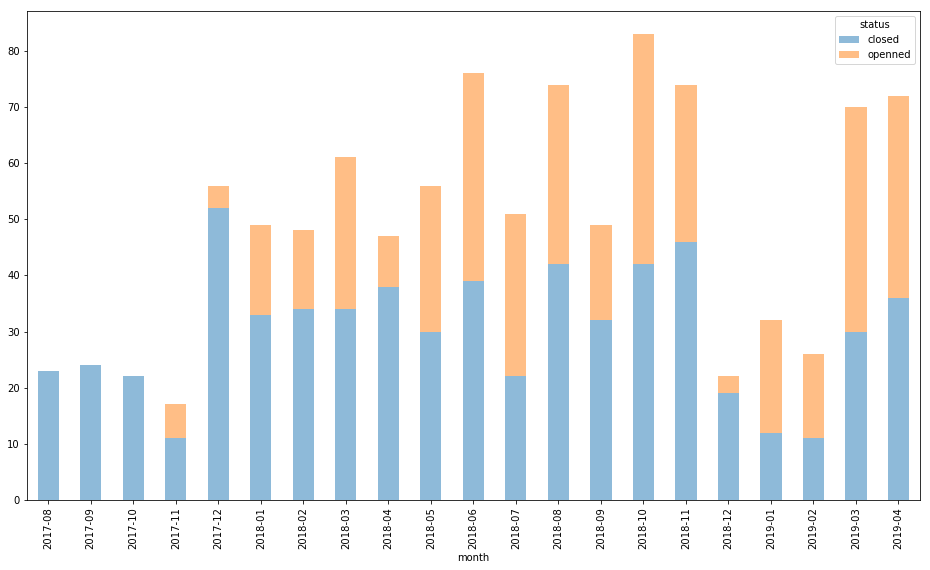

In [14]:
by_month[['closed', 'openned']].plot(kind='bar', stacked=True, figsize=(16,9), alpha=0.5)

In [15]:
threads.columns

Index(['_id', 'date', 'msg', 'name', 'ticket_id', 'ticket', 'year', 'title',
       'status', 'month'],
      dtype='object')

In [16]:
output = threads
output['msg'] = threads['msg'].apply(lambda x: str(x)[0:63].replace('\n', ' ').replace('\r', '').strip())
output['title'] = threads['title'].apply(lambda x: str(x).replace('\n', ' ').replace('\r', '').strip())

In [17]:
output[['year', 'ticket', 'date', 'title', 'msg', 'status']].sort_values('date').to_csv('output_tickets.csv', index=False)

## Forecast

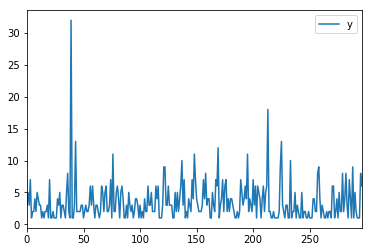

In [23]:
by_day = threads.groupby('date').count()['_id'].reset_index()
by_day.rename(columns={'date': 'ds', '_id': 'y'}, inplace=True)
by_day.plot()

In [24]:
m = Prophet()
m.fit(by_day)

/usr/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [25]:
future = m.make_future_dataframe(periods=180)
forecast = m.predict(future)

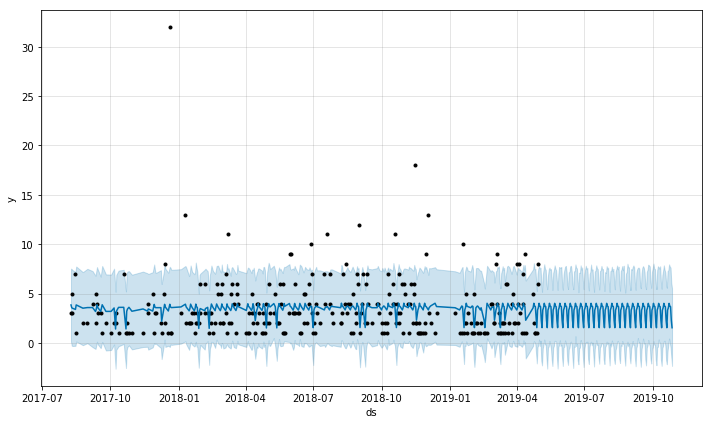

In [30]:
f = m.plot(forecast)

In [31]:
f.savefig('forecast.png')